PackedSequence 와 PaddedSequence

RNN/LSTM 계열의 모델에서 sequence batch를 잘 활용할 수 있는 PackedSequence 와 PaddedSequence를 만드는 방법을 학습

PyTorch 라이브러리 안에 있는 4가지 함수
=> pad_sequence, pack_sequence, pack_padded_sequence, pad_packed_sequence

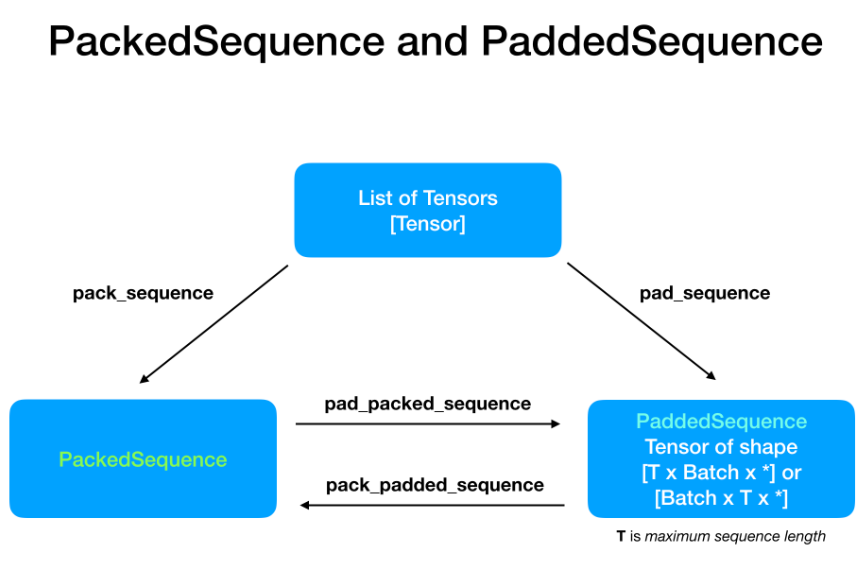

In [1]:
import torch
import numpy as np
from torch.nn.utils.rnn import pad_sequence, pack_sequence, pack_padded_sequence, pad_packed_sequence

예제 데이터

실습을 위한 간단한 예제 데이터. 기억할 점은 batch size가 5이고, sequence 중 가장 긴 길이는 13라는 것임.

In [2]:
#Random word from random word generator
data = ['hello world',
        'midnight',
        'calculation',
        'path',
        'short circuit']

#Make dictionary
char_set = ['<pad>'] + list(set(char for seq in data for char in seq))  # Get all characters and include pad token
char2idx = {char: idx for idx, char in enumerate(char_set)}     # Constuct character to index dictionary
print('char_set:', char_set)
print('char_set length:', len(char_set))

char_set: ['<pad>', 'p', 'd', 'l', 'a', 'e', 'o', 'm', 'g', 'c', 'r', 'u', 'w', 's', 'i', 't', 'h', 'n', ' ']
char_set length: 19


In [3]:
#Convert character to index and make list of tensors
X = [torch.LongTensor([char2idx[char] for char in seq]) for seq in data]

#Check converted result
for sequence in X:
    print(sequence)

tensor([16,  5,  3,  3,  6, 18, 12,  6, 10,  3,  2])
tensor([ 7, 14,  2, 17, 14,  8, 16, 15])
tensor([ 9,  4,  3,  9, 11,  3,  4, 15, 14,  6, 17])
tensor([ 1,  4, 15, 16])
tensor([13, 16,  6, 10, 15, 18,  9, 14, 10,  9, 11, 14, 15])


위와 같이 sequence 길이가 제각각인 것을 확인가능

In [4]:
#Make length tensor (will be used later in 'pack_padded_sequence' function)
lengths = [len(seq) for seq in X]
print('lengths:', lengths)

lengths: [11, 8, 11, 4, 13]


Sequence 데이터의 경우 어떻게 batch로 묶을까?

위와 같이 Text 나 audio 처럼 sequence 형식인 데이터의 경우 길이가 각각 다 다르기 때문에
하나의 batch로 만들어 주기 위해서 일반적으로 제일 긴 sequence 길이에 맞춰 뒷부분에 padding을 추가해준다.
이 방식이 일반적으로 많이 쓰이는 padding 방식이다.
하지만 PyTorch에서는 PackedSequence 라는 것을 쓰면 padding 없이도 정확히 필요한 부분까지만 병렬 계산을 할 수 있다.

pad_sequence 함수를 이용하여 PaddedSequence(그냥 Tensor) 만들기

PaddedSequence는 sequence 중에서 가장 긴 sequence 와 길이를 맞추어지기 위해 padding 을 추가한 일반적인 Tensor 를 말한다.
이때, pad_sequence 라는 PyTorch 기본 라이브러리 함수를 이용하면 쉽게 padding 을 추가할 수 있다.
여기서 주의할 점은 input이 Tensor 들의 list 로 주어져야 한다. (Tensor들의 list)
list 안에 있는 각각의 Tensor 들의 shape 가 (?, a, b, ...) 라고 할 때, (여기서 ?는 각각 다른 sequence length)
pad_sequence 함수를 쓰면 (T, batch_size, a, b, ...) shape를 가지는 Tensor 가 리턴된다. (여기서 T는 batch 안에서 가장 큰 sequence length)
만약, pad_sequence 에 명시적으로 batch_first=True 라는 파라미터를 지정해주면,
(batch_size, T, a, b, ...) shape를 가지는 Tensor가 리턴된다.
기본적으로 padding 값은 0으로 되어있지만, padding_value=42 와 같이 파라미터를 지정해주면, padding 하는 값도 정할 수 있다.

In [5]:
# Make a Tensor of shape (Batch x Maximum_Sequence_Length)
padded_sequence = pad_sequence(X, batch_first=True) # X is now padded sequence
print(padded_sequence)
print(padded_sequence.shape)

tensor([[16,  5,  3,  3,  6, 18, 12,  6, 10,  3,  2,  0,  0],
        [ 7, 14,  2, 17, 14,  8, 16, 15,  0,  0,  0,  0,  0],
        [ 9,  4,  3,  9, 11,  3,  4, 15, 14,  6, 17,  0,  0],
        [ 1,  4, 15, 16,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [13, 16,  6, 10, 15, 18,  9, 14, 10,  9, 11, 14, 15]])
torch.Size([5, 13])


pack_sequence 함수를 이용하여 PackedSequence 만들기

PackedSequence 는 위와 같이 padding token 을 추가하여 sequence 의 최대 길이에 맞는 Tensor 를 만드는 게 아닌,
padding 을 추가하지 않고 정확히 주어진 sequence 길이까지만 모델이 연산을 하게끔 만드는 PyTorch의 자료구조이다.
이 PackedSequence를 만들기 위해서는 한가지 조건이 필요하다.

● 주어지는 input (list of Tensor)는 길이에 따른 내림차순으로 정렬이 되어있어야 한다.

따라서 먼저 input을 길이에 따른 내림차순으로 정렬해본다.

In [6]:
# Sort by descending lengths
sorted_idx = sorted(range(len(lengths)), key=lengths.__getitem__, reverse=True)
sorted_X = [X[idx] for idx in sorted_idx]

# Check converted result
for sequence in sorted_X:
    print(sequence)

tensor([13, 16,  6, 10, 15, 18,  9, 14, 10,  9, 11, 14, 15])
tensor([16,  5,  3,  3,  6, 18, 12,  6, 10,  3,  2])
tensor([ 9,  4,  3,  9, 11,  3,  4, 15, 14,  6, 17])
tensor([ 7, 14,  2, 17, 14,  8, 16, 15])
tensor([ 1,  4, 15, 16])


input Tensor 가 정렬되었으니 pack_sequence 를 이용하여 PackedSequence 를 만들어 본다.

In [7]:
packed_sequence = pack_sequence(sorted_X)
print(packed_sequence)

PackedSequence(data=tensor([13, 16,  9,  7,  1, 16,  5,  4, 14,  4,  6,  3,  3,  2, 15, 10,  3,  9,
        17, 16, 15,  6, 11, 14, 18, 18,  3,  8,  9, 12,  4, 16, 14,  6, 15, 15,
        10, 10, 14,  9,  3,  6, 11,  2, 17, 14, 15]), batch_sizes=tensor([5, 5, 5, 5, 4, 4, 4, 4, 3, 3, 3, 1, 1]), sorted_indices=None, unsorted_indices=None)


Embedding 적용해보기

PackedSequence 와 padding 이 된 Tensor 인 PaddedSequence 를 만들어보았으니, RNN에 input으로 넣어서 테스트를 해본다.

그 전에, 위 예제들에서는 input 이 character 의 index 들을 가지고 있는 데이터였지만, 보통은 주로 이를 embedding 한 값을 RNN 의 input으로 넣어준다.

아래 예제에서는 one-hot character embedding 을 해본다.

In [8]:
# one-hot embedding using PaddedSequence
eye = torch.eye(len(char_set)) # Identity matrix of shape (len(char_set), len(char_set))
embedded_tensor = eye[padded_sequence]
print(embedded_tensor.shape) # shape: (Batch_size, max_sequence_length, number_of_input_tokens)

torch.Size([5, 13, 19])


In [9]:
# one-hot embedding using PackedSequence
embedded_packed_seq = pack_sequence([eye[X[idx]] for idx in sorted_idx])
print(embedded_packed_seq.data.shape)

torch.Size([47, 19])


RNN 모델 만들기

간단한 RNN 모델을 만들어 본다.

In [10]:
# declare RNN
rnn = torch.nn.RNN(input_size=len(char_set), hidden_size=30, batch_first=True)

PaddedSequence 를 이용하여 RNN 에 넣어본다.

In [11]:
rnn_output, hidden = rnn(embedded_tensor)
print(rnn_output.shape) # shape: (batch_size, max_seq_length, hidden_size)
print(hidden.shape)     # shape: (num_layers * num_directions, batch_size, hidden_size)

torch.Size([5, 13, 30])
torch.Size([1, 5, 30])


PackedSequence 를 이용하여 RNN 에 넣어본다.

In [12]:
rnn_output, hidden = rnn(embedded_packed_seq)
print(rnn_output.data.shape)
print(hidden.data.shape)

torch.Size([47, 30])
torch.Size([1, 5, 30])


pad_packed_sequence

위 함수는 PackedSequence 를 PaddedSequence(Tensor) 로 바꾸어주는 함수이다.

PackedSequence 는 각 sequence에 대한 길이 정보도 가지고 있기 때문에, 이 함수는 Tensor 와 함께 길이에 대한 리스트를 튜플로 리턴해준다.
리턴값 : (Tensor, list_of_lengths)

In [13]:
unpacked_sequence, seq_lengths = pad_packed_sequence(embedded_packed_seq, batch_first=True)
print(unpacked_sequence.shape)
print(seq_lengths)

torch.Size([5, 13, 19])
tensor([13, 11, 11,  8,  4])


pack_padded_sequence

반대로, Padding 이 된 Tensor 인 PaddedSequence 를 PackedSequence 로 바꾸어주는 함수도 있다.
pack_paddrd_sequence 함수는 실제 sequence 길이에 대한 정보를 모르기 때문에, 파라미터로 꼭 제공해주어야 한다.

여기서 주의할 점은, input 인 PaddedSequence 가 아까 언급한 '길이에 따른 내림차순으로 정렬되어야 한다는' 조건이 성립되어야 PackedSequence 로 올바르게 변환될 수 있다.

아까 만든 padded_sequence 변수는 이 조건을 만족하지 않기 때문에 다시 새로 만든다.

In [14]:
embedded_padded_sequence = eye[pad_sequence(sorted_X, batch_first=True)]
print(embedded_padded_sequence.shape)

torch.Size([5, 13, 19])


이제, 이 padding이 된 Tensor를 PackedSequence로 변환해보겠다.

In [15]:
sorted_lengths = sorted(lengths, reverse=True)
new_packed_sequence = pack_padded_sequence(embedded_padded_sequence, sorted_lengths, batch_first=True)
print(new_packed_sequence.data.shape)
print(new_packed_sequence.batch_sizes)

torch.Size([47, 19])
tensor([5, 5, 5, 5, 4, 4, 4, 4, 3, 3, 3, 1, 1])
